
# AWS 기반 머신 러닝 ETL 파이프라인을 통한 다중 분류 예측 모델링

### 프로젝트 설명:
이 프로젝트는 AWS 오픈소스를 활용하여 [MIT Supercloud Dataset](https://registry.opendata.aws/dcc/)을 이용한 다중 분류 예측 모델을 개발하는 것입니다. 데이터 수집, 정제 및 변환(ETL) 과정은 AWS 서비스(AWS S3, AWS Glue)를 통해 자동화되며, 머신 러닝 모델의 학습과 예측은 AWS SageMaker에서 수행됩니다.

### 주요 목표:
1. **데이터 수집**: MIT Supercloud 시스템에서 수집된 대규모 모니터링 데이터를 AWS S3에 저장하여 관리합니다.
2. **데이터 정제 및 ETL**: 수집된 데이터를 클렌징하고 변환하여 머신 러닝 모델 학습에 적합한 형태로 준비합니다. 이 과정에는 데이터 조인 및 aggregation 형태의 테이블로 저장하는 것이 포함됩니다.
3. **모델 구축 및 예측**: SageMaker에서 학습 스크립트를 작성하고, 머신 러닝 라이브러리를 활용하여 모델을 구성합니다. 이후 모델 성능을 평가하여 최고 성능의 모델을 선정합니다.

해당 프로젝트는 AWS 인프라를 활용하여 효율적인 빅데이터 처리와 저장, 모델 학습까지 AWS SageMaker와 ETL 워크플로우를 사용하여 설계하였습니다. 🌟

## 1. Install Libraries

In [1]:
!pip install catboost lightgbm xgboost
!pip install pandas numpy boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 16.6 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 13.9 MB/s eta 0:00:00:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 46.5 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 5.0 MB/s eta 0:00:00
  Created wheel for lightgbm: filename=lightgbm-4.5.0-py3-none-linux_x86_64.whl size=2740292 sha256=1b8b5e95d9b08769ccffb35f7f08dc76ee656c4c8de37199c26510ef1a0b46ed
  Stored in directory: /home/ec2-user/.cache/pip/wheels/7c/16/bf/61bc6295609c0752bc0f5b774a41f3413bca3afe3a73d2e47d
Successfully built lightgbm


## 2. Data Loading
AWS S3으로 부터 CSV 파일을 로드합니다.

In [18]:
import pandas as pd
import boto3

s3 = boto3.client('s3')

# s3에서 데이터 로드
df = pd.read_csv('s3a://testawsbucket-01/output/merged_df.csv/part-00000-bbb9f4ff-1108-4b02-96b3-7188aa8d7ccf-c000.csv', low_memory=False)
print(df)

                id_job    id_array_job  id_array_task         id_user  \
0       65590191436871  14108987335445            114  87509498710061   
1       64310074400647  61177129314629            600  42770088536256   
2       34191949612627  14108987335445            115  87509498710061   
3       21630303188597  61177129314629            601  42770088536256   
4       10343100598054  61177129314629            602  42770088536256   
...                ...             ...            ...             ...   
395909  75124122894379  16618712154521     4294967294   1706828023724   
395910  37802476679519  16618712154521     4294967294   1706828023724   
395911   9807128696900  38040778438207            109  48065336140816   
395912  42865228158509  38040778438207            110  48065336140816   
395913  36690157579853  38040778438207            111  48065336140816   

           kill_requid  nodes_alloc  cpus_req  derived_ec  exit_code  \
0       61026541062099            1        20      

## 3. Pre-processing
결측치 및 범주형 변수 인코딩 작업을 수행합니다.
(일부 전처리와 피처 엔지니어링 과정은 ETL 과정에서 수행)

In [19]:
df.info()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395914 entries, 0 to 395913
Data columns (total 46 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id_job                395914 non-null  int64  
 1   id_array_job          395914 non-null  int64  
 2   id_array_task         395914 non-null  int64  
 3   id_user               395914 non-null  int64  
 4   kill_requid           395914 non-null  int64  
 5   nodes_alloc           395914 non-null  int64  
 6   cpus_req              395914 non-null  int64  
 7   derived_ec            395914 non-null  int64  
 8   exit_code             395914 non-null  int64  
 9   gres_used             0 non-null       float64
 10  array_max_tasks       395914 non-null  int64  
 11  array_task_pending    395914 non-null  int64  
 12  constraints           395914 non-null  object 
 13  flags                 395914 non-null  int64  
 14  mem_req               395914 non-null  uint64 
 15  

id_job                       0
id_array_job                 0
id_array_task                0
id_user                      0
kill_requid                  0
nodes_alloc                  0
cpus_req                     0
derived_ec                   0
exit_code                    0
gres_used               395914
array_max_tasks              0
array_task_pending           0
constraints                  0
flags                        0
mem_req                      0
partition                    0
priority                     0
state                        0
timelimit                    0
time_suspended               0
track_steps                  0
job_type                     0
is_gpu                       0
time_duration                0
submission_delay             0
tres_req_cpu                 0
tres_alloc_cpu               0
tres_req_mem                 0
tres_alloc_mem               0
tres_req_energy              0
tres_alloc_energy            0
tres_req_node                0
tres_all

In [20]:
# 결측치 채우기

df['gres_used'] = df['gres_used'].fillna(0)
df['model'] = df['model'].fillna('NONE')

In [21]:
# object 타입의 열만 선택
object_columns = df.select_dtypes(include=['object'])

for col in object_columns.columns:
    print(col, df[col].unique())

constraints ['xeon-g6' 'xeon-g6&6248' '\\N' 'opteron' 'xeon-e5' 'opteron&6274'
 'xeon-p8']
partition ['normal' 'gaia' 'xeon-p8' 'db' 'test']
job_type ['OTHER' 'LLSUB:INTERACTIVE' 'LLSUB:BATCH' 'LLMAPREDUCE:MAP']
model ['NONE' 'U5-64' 'U4-32' 'U4-64' 'U3-32' 'U4-128' 'U3-64' 'U5-128' 'U3-128'
 'U5-32' 'inception3' 'resnet50' 'vgg16' 'resnet50_v1.5' 'resnet101'
 'resnet101_v2' 'resnet152' 'resnet152_v2' 'vgg11' 'vgg19' 'inception4'
 'schnet' 'dimenet' 'conv' 'pna' 'bert-base-uncased'
 'distilbert-base-uncased']


In [22]:
# 범주형 변수 원-핫 인코딩
df = pd.get_dummies(df, columns=['constraints', 'partition', 'job_type'])


In [23]:
# 컬럼 이름 정제
df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

In [24]:
df

,id_job,id_array_job,id_array_task,id_user,kill_requid,nodes_alloc,cpus_req,derived_ec,exit_code,gres_used,...,constraints_xeon_p8,partition_db,partition_gaia,partition_normal,partition_test,partition_xeon_p8,job_type_LLMAPREDUCE_MAP,job_type_LLSUB_BATCH,job_type_LLSUB_INTERACTIVE,job_type_OTHER
0,65590191436871,14108987335445,114,87509498710061,61026541062099,1,20,0,0,0.0,...,0,0,0,1,0,0,0,0,0,1
1,64310074400647,61177129314629,600,42770088536256,61026541062099,1,20,0,0,0.0,...,0,0,0,1,0,0,0,0,0,1
2,34191949612627,14108987335445,115,87509498710061,61026541062099,1,20,0,0,0.0,...,0,0,0,1,0,0,0,0,0,1
3,21630303188597,61177129314629,601,42770088536256,61026541062099,1,20,0,0,0.0,...,0,0,0,1,0,0,0,0,0,1
4,10343100598054,61177129314629,602,42770088536256,61026541062099,1,20,0,0,0.0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395909,75124122894379,16618712154521,4294967294,1706828023724,61026541062099,1,10,0,0,0.0,...,0,0,0,1,0,0,0,0,0,1
395910,37802476679519,16618712154521,4294967294,1706828023724,61026541062099,1,10,0,0,0.0,...,0,0,0,1,0,0,0,0,0,1
395911,9807128696900,38040778438207,109,48065336140816,61026541062099,1,20,0,0,0.0,...,0,0,0,1,0,0,0,0,0,1
395912,42865228158509,38040778438207,110,48065336140816,61026541062099,1,20,0,0,0.0,...,0,0,0,1,0,0,0,0,0,1


## 4. Model Training
### 4-1. Data Splitting

In [25]:
from sklearn.preprocessing import LabelEncoder

# 'model' 컬럼 라벨 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['model'])
df = df.drop('model', axis=1)

In [26]:
from sklearn.model_selection import train_test_split

X = df
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

### 4-2. LightGBM 
LGBM 모델을 학습시킨 후, log loss를 계산합니다.

In [16]:
import numpy as np
import lightgbm as lgb
from sklearn.metrics import log_loss

# 1. LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

params_lgb = {
    'objective': 'multiclass',
    'metric': 'multi_logloss',
    'num_class': len(np.unique(y_train)),
    'learning_rate': 0.01,
    'num_leaves': 31
}

lgb_model = lgb.train(
    params_lgb,
    train_data,
    valid_sets=[valid_data],
    callbacks=[lgb.early_stopping(stopping_rounds=3), lgb.log_evaluation(period=100)]
)

# 예측 결과의 확률을 계산
lgb_pred = lgb_model.predict(X_valid, raw_score=False)

# 모델 저장
with open('model/lgb_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051984 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2992
[LightGBM] [Info] Number of data points in the train set: 277139, number of used features: 42
[LightGBM] [Info] Start training from score -0.008752
[LightGBM] [Info] Start training from score -7.787342
[LightGBM] [Info] Start training from score -7.813776
[LightGBM] [Info] Start training from score -7.822744
[LightGBM] [Info] Start training from score -7.778684
[LightGBM] [Info] Start training from score -7.744783
[LightGBM] [Info] Start training from score -7.787342
[LightGBM] [Info] Start training from score -7.897545
[LightGBM] [Info] Start training from score -7.859446
[LightGBM] [Info] Start training from score -7.850143
[LightGBM] [Info] Start training from score -7.562461
[LightGBM] [Info] Start training from score -9.53654

In [28]:
# 모델 불러오기
with open('model/lgb_model.pkl', 'rb') as f:
    lgb_model = pickle.load(f)
    
# 로그 손실 계산
lgb_log_loss = log_loss(y_valid, lgb_pred)
print(f'LightGBM Log Loss: {lgb_log_loss}')

LightGBM Log Loss: 0.039559376525427056


### 4-3. XGBoost
XGBoost 모델을 학습시킨 후, log_loss를 계산합니다.

In [17]:
# 2. XGBoost
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

params_xgb = {
    'objective': 'multi:softprob',
    'num_class': len(np.unique(y_train)),
    'eval_metric': 'mlogloss',
    'max_depth': 6,
    'learning_rate': 0.01
}

xgb_model = xgb.train(params_xgb, dtrain, num_boost_round=800, 
                       evals=[(dvalid, 'eval')],
                       early_stopping_rounds=3, 
                       verbose_eval=True)


with open('model/xgb_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


[0]	eval-mlogloss:3.16233
[1]	eval-mlogloss:3.04572
[2]	eval-mlogloss:2.94197
[3]	eval-mlogloss:2.84861
[4]	eval-mlogloss:2.76359
[5]	eval-mlogloss:2.68562
[6]	eval-mlogloss:2.61358
[7]	eval-mlogloss:2.54656
[8]	eval-mlogloss:2.48399
[9]	eval-mlogloss:2.42529
[10]	eval-mlogloss:2.36999
[11]	eval-mlogloss:2.31772
[12]	eval-mlogloss:2.26817
[13]	eval-mlogloss:2.22107
[14]	eval-mlogloss:2.17619
[15]	eval-mlogloss:2.13334
[16]	eval-mlogloss:2.09234
[17]	eval-mlogloss:2.05303
[18]	eval-mlogloss:2.01529
[19]	eval-mlogloss:1.97902
[20]	eval-mlogloss:1.94408
[21]	eval-mlogloss:1.91038
[22]	eval-mlogloss:1.87787
[23]	eval-mlogloss:1.84643
[24]	eval-mlogloss:1.81601
[25]	eval-mlogloss:1.78657
[26]	eval-mlogloss:1.75802
[27]	eval-mlogloss:1.73034
[28]	eval-mlogloss:1.70345
[29]	eval-mlogloss:1.67731
[30]	eval-mlogloss:1.65191
[31]	eval-mlogloss:1.62719
[32]	eval-mlogloss:1.60314
[33]	eval-mlogloss:1.57968
[34]	eval-mlogloss:1.55682
[35]	eval-mlogloss:1.53453
[36]	eval-mlogloss:1.51278
[37]	eval-m

In [29]:
# 모델 불러오기
with open('model/xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)


xgb_pred = xgb_model.predict(dvalid)
xgb_log_loss = log_loss(y_valid, xgb_pred)
print(f'XGBoost Log Loss: {xgb_log_loss}')

XGBoost Log Loss: 0.014970162926073114


### 4-4. CatBoost
CatBoost 모델을 학습하고 Log loss를 계산합니다.

In [30]:
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import log_loss

# Pool 객체 생성
train_pool = Pool(X_train, y_train)
valid_pool = Pool(X_valid, y_valid)

# CatBoost 모델 설정
cat_model = CatBoostClassifier(
    iterations=800,
    learning_rate=0.01,
    depth=6,
    eval_metric='MultiClass',
    early_stopping_rounds=3,
    verbose=100
)

# 모델 훈련
cat_model.fit(train_pool, eval_set=valid_pool)

# 모델 저장
cat_model.save_model('model/catboost_model.cbm')

# 유효성 검증 데이터에 대한 예측 확률 계산
cat_proba = cat_model.predict_proba(X_valid)

0:	learn: 3.0421453	test: 3.0421260	best: 3.0421260 (0)	total: 3.62s	remaining: 48m 15s
100:	learn: 0.4585894	test: 0.4587148	best: 0.4587148 (100)	total: 4m 53s	remaining: 33m 53s
200:	learn: 0.1676410	test: 0.1680166	best: 0.1680166 (200)	total: 9m 46s	remaining: 29m 6s
300:	learn: 0.0753511	test: 0.0759504	best: 0.0759504 (300)	total: 14m 33s	remaining: 24m 7s
400:	learn: 0.0417516	test: 0.0424589	best: 0.0424589 (400)	total: 19m 23s	remaining: 19m 17s
500:	learn: 0.0287953	test: 0.0296128	best: 0.0296128 (500)	total: 24m 13s	remaining: 14m 27s
600:	learn: 0.0235552	test: 0.0244993	best: 0.0244993 (600)	total: 29m 3s	remaining: 9m 37s
700:	learn: 0.0211000	test: 0.0221508	best: 0.0221508 (700)	total: 33m 55s	remaining: 4m 47s
799:	learn: 0.0196817	test: 0.0208445	best: 0.0208445 (799)	total: 38m 40s	remaining: 0us

bestTest = 0.02084445817
bestIteration = 799



In [31]:
# 모델 불러오기
cat_model = CatBoostClassifier()
cat_model.load_model('model/catboost_model.cbm')

# 예측 및 로그 손실 계산
cat_pred = cat_model.predict_proba(X_valid)
cat_log_loss = log_loss(y_valid, cat_pred)
print(f'CatBoost Log Loss: {cat_log_loss}')

CatBoost Log Loss: 0.020844458168259982


In [32]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, log_loss
import numpy as np

# 예측값을 클래스 레이블로 변환
lgb_pred_probs = lgb_model.predict(X_test)  # LightGBM
lgb_pred_classes = np.argmax(lgb_pred_probs, axis=1)

cat_pred_probs = cat_model.predict_proba(X_test)  # CatBoost
cat_pred_classes = np.argmax(cat_pred_probs, axis=1)

xgb_pred_probs = xgb_model.predict(xgb.DMatrix(X_test))  # XGBoost
xgb_pred_classes = np.argmax(xgb_pred_probs, axis=1)

# 평가 지표 계산
lgb_accuracy = accuracy_score(y_test, lgb_pred_classes)
cat_accuracy = accuracy_score(y_test, cat_pred_classes)
xgb_accuracy = accuracy_score(y_test, xgb_pred_classes)

lgb_f1 = f1_score(y_test, lgb_pred_classes, average='macro')
cat_f1 = f1_score(y_test, cat_pred_classes, average='macro')
xgb_f1 = f1_score(y_test, xgb_pred_classes, average='macro')

lgb_log_loss = log_loss(y_test, lgb_pred_probs)
cat_log_loss = log_loss(y_test, cat_pred_probs)
xgb_log_loss = log_loss(y_test, xgb_pred_probs)


# 결과 출력
print(f"LightGBM Accuracy: {lgb_accuracy}")
print(f"CatBoost Accuracy: {cat_accuracy}")
print(f"XGBoost Accuracy: {xgb_accuracy}")

print(f"LightGBM F1 Score: {lgb_f1}")
print(f"CatBoost F1 Score: {cat_f1}")
print(f"XGBoost F1 Score: {xgb_f1}")

print(f"LightGBM Log Loss: {lgb_log_loss}")
print(f"CatBoost Log Loss: {cat_log_loss}")
print(f"XGBoost Log Loss: {xgb_log_loss}")



LightGBM Accuracy: 0.993921330908601
CatBoost Accuracy: 0.9936182393749579
XGBoost Accuracy: 0.9952178891358524
LightGBM F1 Score: 0.34894963308484184
CatBoost F1 Score: 0.21656284148428812
XGBoost F1 Score: 0.4806086176681141
LightGBM Log Loss: 0.038627094725259575
CatBoost Log Loss: 0.020258741888348437
XGBoost Log Loss: 0.014484913822888416


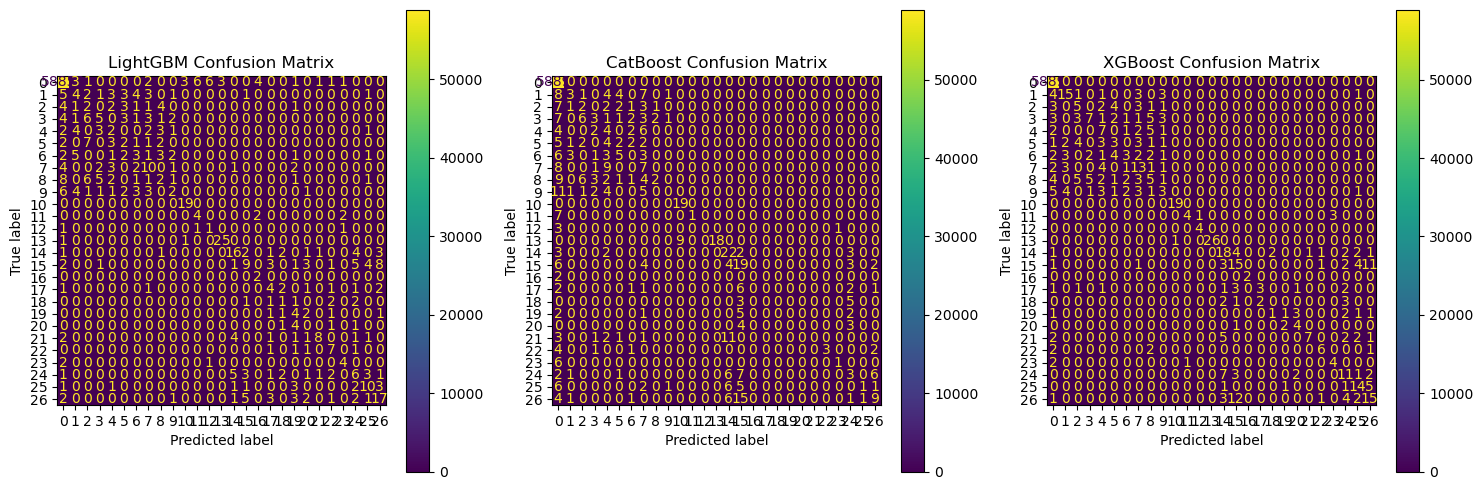

In [33]:
import matplotlib.pyplot as plt

# Confusion Matrix
lgb_cm = confusion_matrix(y_test, lgb_pred_classes)
cat_cm = confusion_matrix(y_test, cat_pred_classes)
xgb_cm = confusion_matrix(y_test, xgb_pred_classes)

# Visualize Confusion Matrix
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ConfusionMatrixDisplay(confusion_matrix=lgb_cm).plot(ax=ax[0])
ax[0].set_title('LightGBM Confusion Matrix')

ConfusionMatrixDisplay(confusion_matrix=cat_cm).plot(ax=ax[1])
ax[1].set_title('CatBoost Confusion Matrix')

ConfusionMatrixDisplay(confusion_matrix=xgb_cm).plot(ax=ax[2])
ax[2].set_title('XGBoost Confusion Matrix')

plt.tight_layout()
plt.show()